# Aplicación de Double UNet en base de datos braTS2021

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tqdm import tqdm


import os
import numpy as np
import cv2
import json
from glob import glob
from sklearn.utils import shuffle
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model

from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import *
from sklearn.model_selection import train_test_split

import random as r
import skimage.io as io

# Modelo

In [2]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
#     num_filters = [256, 128, 64, 32]
    num_filters = [128, 64, 32, 16]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

# def encoder2(inputs):
#     skip_connections = []
#
#     output = DenseNet121(include_top=False, weights='imagenet')(inputs)
#     model = tf.keras.models.Model(inputs, output)
#
#     names = ["input_2", "conv1/relu", "pool2_conv", "pool3_conv"]
#     for name in names:
#         skip_connections.append(model.get_layer(name).output)
#     output = model.get_layer("pool4_conv").output
#
#     return output, skip_connections

def encoder2(inputs):
#     num_filters = [32, 64, 128, 256]
    num_filters = [16, 32, 64, 128]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
#     num_filters = [256, 128, 64, 32]
    num_filters = [128, 64, 32, 16]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    outputs = Concatenate()([outputs1, outputs2])

    model = Model(inputs, outputs)
    return model


# Auxiliary functions

In [11]:
def create_dir(path):
    """ Create a directory. """
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"Error: creating directory with name {path}")

def read_data(x, y):
    """ Read the image and mask from the given path. """
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    return image, mask

def read_params():
    """ Reading the parameters from the JSON file."""
    with open("params.json", "r") as f:
        data = f.read()
        params = json.loads(data)
        return params

def load_data(path):
    """ Loading the data from the given path. """
    images_path = os.path.join(path, "image/*")
    masks_path  = os.path.join(path, "mask/*")

    images = glob(images_path)
    masks  = glob(masks_path)

    return images, masks

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_model_weight(path):
    with CustomObjectScope({
        'dice_loss': dice_loss,
        'dice_coef': dice_coef,
        'bce_dice_loss': bce_dice_loss,
        'focal_loss': focal_loss,
        'iou': iou
        }):
        model = load_model(path)
    return model

In [21]:
def read_image(x):
#     x = x.decode()
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    return image

def read_mask(y):
#     y = y.decode()
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = mask/255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

def parse_data(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        y = np.concatenate([y, y], axis=-1)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([192, 256, 3])
    y.set_shape([192, 256, 2])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=32)
    dataset = dataset.map(map_func=parse_data)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch)
    return dataset


# Metrics

In [7]:

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
    alpha=0.25
    gamma=2
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

# Para pre-procesar imagenes

In [8]:

def seg_rangos(path, end, size_wh=128):
    files = glob(path+end, recursive=True)
    xmin=3000
    xmax=0
    r.seed(42)
    r.shuffle(files)
    for file in files:
        img = io.imread(file, plugin="simpleitk")
        img.astype("float32")
#         print(img.shape)
        for slice in range(img.shape[0]):
            
            img_s = img[slice,:,:]
            img_s = cv2.resize(img_s, (size_wh,size_wh))
            if (np.sum(img_s) > 0):
                xmax = slice if slice >= xmax else xmax 
                xmin = slice if slice <= xmin else xmin             
    return xmin, xmax

def seg_to_array(path, end, rangoMin = 0, rangoMax = 200, size_wh=128):
    files = glob(path+end, recursive=True)
    img_list = []
    r.seed(42)
    r.shuffle(files)    
    for file in files:
#         print(rutaFile)
        img = io.imread(file , plugin="simpleitk")
        img[img != 0] = 1
        img.astype("float32")
        
        for slice in range(rangoMin,rangoMax):
            img_s = img[slice,:,:]
            img_s = cv2.resize(img_s, (size_wh,size_wh))
            
#             img_s = img_s/255.0
#             img_s = img_s.astype(np.float32)
            img_s = np.expand_dims(img_s, axis=0)    
            img_s = np.concatenate([img_s, img_s])
            img_list.append(img_s)            
    return np.array(img_list,np.float32)

def to_array(path, end, rangoMin = 0, rangoMax = 200, size_wh = 128):
    files = glob(path+end, recursive=True)
    img_list = []    
    r.seed(42)
    r.shuffle(files)    
    for file in files:
        img = io.imread(file)
#         img = (img-img.mean())/img.std()
        for slice in range(rangoMin,rangoMax):
            img_s = img[slice,:,:]
            
            img_s = cv2.resize(img_s, (size_wh,size_wh))
            
#             img_s = np.clip(img_s - np.median(img_s)+127, 0, 255)
#             img_s = img_s/255.0
#             img_s = img_s.astype(np.float32)
            img_s = np.expand_dims(img_s, axis=0)
            img_s = np.concatenate([img_s, img_s, img_s])
            
            img_list.append(img_s)
    return np.array(img_list,np.float32)

def vcrep_kpart(X, y, k=5):
    n = X.shape[0]
    t_pliegue = int(n / k)
    perm = np.random.permutation(n)
    X = X[perm]
    y = y[perm]
    masc_val = np.zeros(n, dtype=bool)
    masc_val[0:t_pliegue] = True
    masc_ent = np.logical_not(masc_val)
    X_ent = X[masc_ent]
    y_ent = y[masc_ent]
    X_val = X[masc_val]
    y_val = y[masc_val]
    return X_ent, y_ent, X_val, y_val

# Training

In [13]:
np.random.seed(42)
tf.random.set_seed(42)
create_dir("files")

train_path = "/kaggle/input/brats2021-sub-data/BraTS2021_Training_Data_Sub/"
# valid_path = "/kaggle/input/d/daliaydom/cvcclinicdb/new_data/valid"
size_img = 128
ruta = train_path
(xMin, xMax) = seg_rangos(path=ruta, end="**/**seg.nii", size_wh=128)
print(xMin, xMax)
# xMin=80
# xMax=140
train_x = to_array(path=ruta, end="**/**flair.nii", rangoMin = xMin, rangoMax = xMax, size_wh=size_img)
train_y = seg_to_array(path=ruta, end="**/**seg.nii", rangoMin = xMin, rangoMax = xMax, size_wh=size_img)
print(train_x.shape)


KeyboardInterrupt: 

In [ ]:
train_x=train_x[:7000]
train_y=train_y[:7000]

In [8]:
try:
    X_ent, y_ent, X_val, y_val = vcrep_kpart(train_x, train_y,k=5)
except Exception as e:
    print('WARNING: No es posible ejecutar: {}'.format(e))    

train_x = tf.transpose(X_ent, [0, 3, 2, 1])
train_y = tf.transpose(y_ent, [0, 3, 2, 1])
valid_x = tf.transpose(X_val, [0, 3, 2, 1])
valid_y = tf.transpose(y_val, [0, 3, 2, 1])

print("Datos de Entrenamiento", X_ent.shape, y_ent.shape)
print("Datos de Validación", X_val.shape, y_val.shape)


2022-12-04 15:59:00.884913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 15:59:00.886305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 15:59:01.059769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 15:59:01.060978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 15:59:01.062056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Datos de Entrenamiento (5600, 3, 128, 128) (5600, 2, 128, 128)
Datos de Validación (1400, 3, 128, 128) (1400, 2, 128, 128)


2022-12-04 15:59:06.601546: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 275251200 exceeds 10% of free system memory.


In [9]:
model_path = "files/model.h5"
batch_size = 16
epochs = 100
lr = 1e-4
shape = (128, 128, 3)

model = build_model(shape)
metrics = [
    dice_coef,
    iou,
    Recall(),
    Precision()
]

# train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
# valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

model.compile(loss=binary_crossentropy, optimizer=Adam(lr), metrics=metrics)

callbacks = [
    ModelCheckpoint(model_path),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20),
    CSVLogger("files/data.csv"),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
]

train_steps = (len(train_x)//batch_size)
valid_steps = (len(valid_x)//batch_size)

if len(train_x) % batch_size != 0:
    train_steps += 1

if len(valid_x) % batch_size != 0:
    valid_steps += 1

80150528/80134624 [==============================] - 1s 0us/step


2022-12-04 15:59:09.247782: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-04 15:59:09.247828: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-04 15:59:09.251757: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2022-12-04 15:59:09.606018: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-04 15:59:09.606204: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [10]:
model.fit(
    train_x, 
    train_y,
    epochs=epochs,
    validation_data=(valid_x, valid_y),
    batch_size=batch_size,
    callbacks=callbacks,
    shuffle=False)

2022-12-04 15:59:09.815324: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1101004800 exceeds 10% of free system memory.
2022-12-04 15:59:10.713496: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 734003200 exceeds 10% of free system memory.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-12-04 15:59:11.411511: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-04 15:59:18.941629: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/350 [..............................] - ETA: 2:16:14 - loss: 0.7585 - dice_coef: 0.0089 - iou: 0.0045 - recall: 0.3446 - precision: 0.0021

2022-12-04 15:59:35.067380: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-04 15:59:35.067432: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/350 [..............................] - ETA: 6:27 - loss: 0.7580 - dice_coef: 0.0151 - iou: 0.0076 - recall: 0.2958 - precision: 0.0031   

2022-12-04 15:59:36.017857: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-04 15:59:36.019785: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-04 15:59:36.198152: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1810 callback api events and 1804 activity events. 
2022-12-04 15:59:36.249567: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-04 15:59:36.316415: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_12_04_15_59_36

2022-12-04 15:59:36.358314: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_12_04_15_59_36/7c10d3150a29.trace.json.gz
2022-12-04 15:59:36.439332: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/pl

350/350 [==============================] - 138s 328ms/step - loss: 0.5625 - dice_coef: 0.0232 - iou: 0.0117 - recall: 0.2702 - precision: 0.0408 - val_loss: 0.4888 - val_dice_coef: 0.0302 - val_iou: 0.0154 - val_recall: 0.3948 - val_precision: 0.1660
Epoch 2/100
350/350 [==============================] - 105s 299ms/step - loss: 0.4122 - dice_coef: 0.0261 - iou: 0.0132 - recall: 0.1669 - precision: 0.2744 - val_loss: 0.4067 - val_dice_coef: 0.0225 - val_iou: 0.0114 - val_recall: 0.0411 - val_precision: 0.3389
Epoch 3/100
350/350 [==============================] - 102s 291ms/step - loss: 0.2872 - dice_coef: 0.0403 - iou: 0.0206 - recall: 0.3438 - precision: 0.5549 - val_loss: 0.2738 - val_dice_coef: 0.0258 - val_iou: 0.0131 - val_recall: 0.0177 - val_precision: 0.7397
Epoch 4/100
350/350 [==============================] - 104s 298ms/step - loss: 0.2040 - dice_coef: 0.0674 - iou: 0.0350 - recall: 0.5680 - precision: 0.7989 - val_loss: 0.2240 - val_dice_coef: 0.0468 - val_iou: 0.0240 - val

In [11]:
import shutil
shutil.make_archive('files', 'zip', '/kaggle/working/files')

'/kaggle/working/files.zip'

# Metrics

In [36]:
import pandas as pd
from matplotlib import pyplot as plt
metrics_trn = pd.read_csv("/kaggle/input/trainingresultsdeeplearningfinalproject/training_results/Training results/DoubleUNetBrain/data.csv")  
metrics_trn = metrics_trn.set_index('epoch')
metrics_trn.head(10)

,dice_coef,iou,loss,lr,precision,recall,val_dice_coef,val_iou,val_loss,val_precision,val_recall
epoch,,,,,,,,,,,
0,0.023152,0.011735,0.562452,0.0001,0.040797,0.270172,0.030234,0.015381,0.488754,0.166026,0.394792
1,0.026056,0.013229,0.412198,0.0001,0.274381,0.166943,0.022513,0.011403,0.406695,0.338904,0.041090
2,0.040308,0.020644,0.287230,0.0001,0.554896,0.343848,0.025780,0.013082,0.273762,0.739660,0.017728
3,0.067377,0.035044,0.203974,0.0001,0.798904,0.568002,0.046805,0.024046,0.223970,0.969448,0.257334
4,0.098112,0.051948,0.154570,0.0001,0.860977,0.767691,0.096253,0.050899,0.149372,0.949670,0.694651
5,0.136668,0.074023,0.119467,0.0001,0.880790,0.857077,0.114218,0.061104,0.137318,0.965751,0.718818
6,0.171752,0.094987,0.093923,0.0001,0.890994,0.874434,0.172456,0.095505,0.092290,0.942642,0.816813
7,0.209631,0.118620,0.073656,0.0001,0.897994,0.879746,0.228515,0.130729,0.064448,0.944470,0.826877
8,0.256063,0.149051,0.057616,0.0001,0.915668,0.900864,0.277297,0.163441,0.051352,0.956014,0.841931


Text(0.5, 1.0, 'Recall')

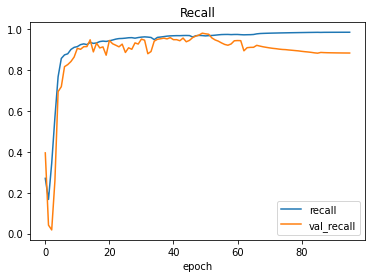

In [37]:
lines = metrics_trn[["recall","val_recall"]].plot.line()
plt.title("Recall")

Text(0.5, 1.0, 'Recall')

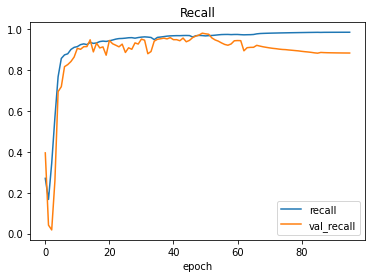

In [38]:
lines = metrics_trn[["recall","val_recall"]].plot.line()
plt.title("Recall")



# Predict

In [84]:
m = load_model_weight("/kaggle/input/trainingresultsdeeplearningfinalproject/training_results/Training results/DoubleUNetBrain/model.h5")

In [93]:
np.random.seed(42)
tf.random.set_seed(42)
# create_dir("files")

train_path = "/kaggle/input/brats2021-sub-data/BraTS2021_Training_Data_Sub/BraTS2021_00343"
size_img = 128
ruta = train_path
(xMin, xMax) = seg_rangos(path=ruta, end="**/**seg.nii", size_wh=128)
print(xMin, xMax)

test_x = to_array(path=ruta, end="**/**flair.nii", rangoMin = xMin, rangoMax = xMax, size_wh=size_img)
test_y = seg_to_array(path=ruta, end="**/**seg.nii", rangoMin = xMin, rangoMax = xMax, size_wh=size_img)
print(test_x.shape,test_y.shape)


42 99
(57, 3, 128, 128) (57, 2, 128, 128)


(1, 2, 128, 128)


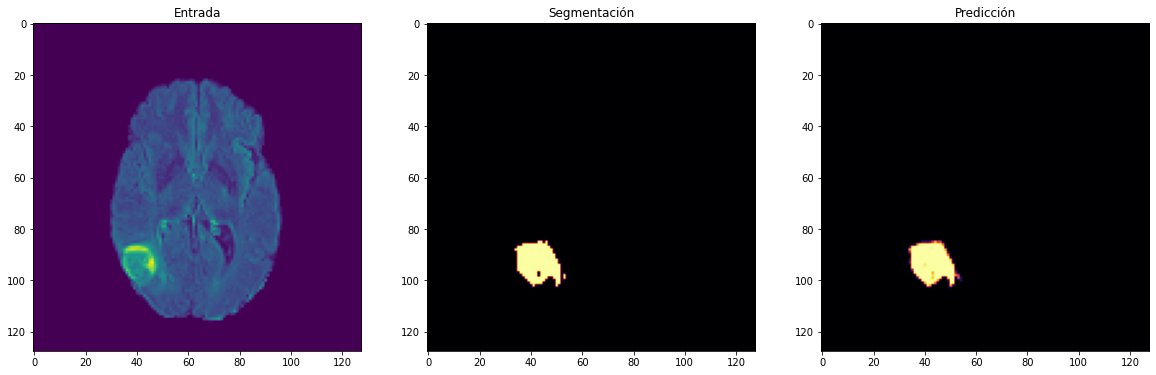

In [94]:
plano=30
X_prueba = test_x
sample = np.expand_dims(X_prueba[plano], axis=0)
sample = tf.transpose(sample, [0, 3, 2, 1])
pred = m.predict(sample)
pred = tf.transpose(pred, [0, 3, 2, 1])

print(pred.shape)

fig = plt.gcf()
fig.set_size_inches(20, 15)
plt.subplot(2,3,1)
plt.title('Entrada')
plt.imshow(X_prueba[plano][0]);

plt.subplot(2,3,2)
plt.title('Segmentación')
plt.imshow(test_y[plano][0],cmap="inferno");

plt.subplot(2,3,3)
plt.title('Predicción')
plt.imshow(pred[0][0],cmap="inferno");

plt.show()